A notebook demostrating the use of Archie's Law to estimate water qulity estimates. The equation is the following.

logCw = logCt – mlogØ

 

where Cw is the predicted fluid EC (S/m), Ct is bulk conductivity and logØ is the free water.

We are trying to estimate fluid EC at on a grid given AEM conductivity (interpolated) and mobile water (interpolated) and a cementation factor based on empirical relationships developed using pore fluid EC and borehole NMR.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import pandas
import rasterio
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import netCDF4
import math
import os, glob
import gc
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from scipy import interpolate, stats
import matplotlib.pyplot as plt

In [3]:
def resample_raster2array(infile, newaff, new_shape, driver='GTiff',
                    null = -999):

    # Open
    src = rasterio.open(infile)

    # Extract data as an array
    arr = src.read()[0]

    # Get the affine
    aff = src.transform


    # Create new array with the grid
    # coordinates from the kriging
    newarr = np.empty(shape=new_shape)

    # Reproject
    reproject(
        arr, newarr,
        src_transform=aff,
        dst_transform=newaff,
        src_crs=src.crs,
        dst_crs=src.crs,
        resampling=Resampling.bilinear)

    src.close()

    # This is a hack to handle different nulls which are always lower than -900
    
    newarr[newarr < -900] = np.nan

    return newarr

def slice_conductivity(logcondprofile, cond_intervals, base, top):
    old_intervals = cond_intervals.copy()
    
    old_intervals[:,0]= old_intervals[:,0] + 0.01

    old_intervals = np.sort(old_intervals.flatten())
    
    # repeat params
    params = np.repeat(logcondprofile, 2)
    
    # Interpolate

    f = interpolate.interp1d(old_intervals,
                             params, kind='linear')
    
    new_intervals = np.array([top,base])
    
    xnew = new_intervals
    
    xnew = xnew[(xnew > np.min(old_intervals)) & (xnew < np.max(old_intervals))]

    xnew = np.sort(np.concatenate((old_intervals, xnew)))

    ynew = f(xnew)
    mask = np.logical_and(xnew <= base, xnew >= top)
    
    new_profile = ynew[mask]
    new_depths = xnew[mask]
    
    # Calculate thickness
    thickness = spatial_functions.depth_to_thickness(new_depths)[:-1]
    # Calculate weights based on thickness
    weights = thickness/(thickness.sum())
    
    # Now multiply these weights by the profile
    weighted_logcond = weights * new_profile[:-1]
    
    return(np.sum(weighted_logcond))
    


In [4]:
# Assign the unit we are calculating the water quality for
#strat = 'Permo-Carb'
strat = 'Cenozoic'

In [5]:
# We also want to reshape the mobile water raster

indir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\mobile_water_content'

if strat == 'Cenozoic':
    infile = os.path.join(indir, 'cenozoic_mobile_water_content.tif')

elif strat == 'Permo-Carb':
    infile = os.path.join(indir, 'permocarb_mobile_water_content.tif')

mob_water_src = rasterio.open(infile)

In [6]:
arr = mob_water_src.read()[0]

# Get the affine
aff = mob_water_src.transform

# GEt log of the water content

logMob = np.log10(arr)

In [7]:
logMob

array([[-1.4191147, -1.41911  , -1.419105 , ..., -1.4923757, -1.4902201,
        -1.4906697],
       [-1.4191091, -1.4191041, -1.4190991, ..., -1.4938848, -1.491738 ,
        -1.4922165],
       [-1.4191034, -1.4190981, -1.4190929, ..., -1.4953686, -1.4932423,
        -1.493759 ],
       ...,
       [-1.4068744, -1.4049491, -1.4028178, ..., -1.4192777, -1.4192779,
        -1.419278 ],
       [-1.4047146, -1.4027   , -1.4004813, ..., -1.4192775, -1.4192777,
        -1.4192779],
       [-1.4027689, -1.4006855, -1.3984017, ..., -1.4192773, -1.4192775,
        -1.4192778]], dtype=float32)

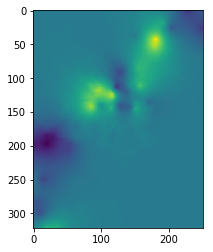

In [8]:
plt.close()
plt.imshow(arr)
plt.show()

In [9]:
# OPen an AEM grid, resample them onto the same affine as the stratigraphy
# and save them as a multiband array

import glob

os.chdir(r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\gdal_grids\grids\layergrids")

cond = np.nan*np.ones(shape = (30, arr.shape[0], arr.shape[1]),
                      dtype = np.float32)
intervals = np.zeros(shape = (30,2), dtype = np.float32)

for i, file in enumerate(glob.glob('*.tif')):
    
    print(file)
    
    cond[i] = resample_raster2array(file, aff, arr.shape,
                                    driver='GTiff', null = 0)
    
    intervals[i] = [float(file.split('_')[2]), float(file.split('_')[3])]
    


layer_29_430.9_500.0_m.tif
layer_30_500.0_Inf_m.tif
layer_28_371.3_430.9_m.tif
layer_27_319.9_371.3_m.tif
layer_26_275.7_319.9_m.tif
layer_25_237.6_275.7_m.tif
layer_24_204.7_237.6_m.tif
layer_23_176.3_204.7_m.tif
layer_22_151.9_176.3_m.tif
layer_21_130.8_151.9_m.tif
layer_20_112.6_130.8_m.tif
layer_19_096.9_112.6_m.tif
layer_18_083.4_096.9_m.tif
layer_17_071.7_083.4_m.tif
layer_16_061.6_071.7_m.tif
layer_15_052.9_061.6_m.tif
layer_14_045.3_052.9_m.tif
layer_13_038.8_045.3_m.tif
layer_12_033.1_038.8_m.tif
layer_11_028.1_033.1_m.tif
layer_10_023.8_028.1_m.tif
layer_09_020.0_023.8_m.tif
layer_08_016.6_020.0_m.tif
layer_07_013.6_016.6_m.tif
layer_06_010.9_013.6_m.tif
layer_05_008.4_010.9_m.tif
layer_04_006.2_008.4_m.tif
layer_03_004.0_006.2_m.tif
layer_02_002.0_004.0_m.tif
layer_01_000.0_002.0_m.tif


In [10]:
# Sort so the first layer is the first matrix in the array

inds = intervals.argsort(axis = 0)[:,0]

intervals = intervals[inds]

cond = cond[inds]


In [11]:
cond_intervals = intervals.copy()

In [12]:
# Create the log conductivity array

logcond =np.log10(cond)


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


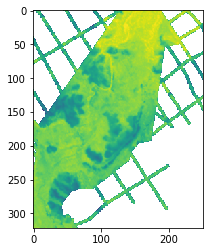

In [13]:
plt.close()
plt.imshow(logcond[0])

plt.show()

In [14]:
# Open


wt_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\raster_elevation_interpolation\nulled\KeepRiver_water_table_mBGL.tif"
wt_depth = resample_raster2array(wt_file, aff, logMob.shape)


strat_dir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\strat_grids'

if strat == 'Permo-Carb':
    
    topfile = os.path.join(strat_dir, "Cuk_Pk_top_mAHD.tif")
    
    basefile = os.path.join(strat_dir, "Cuk_Pk_base.tif")

elif strat == 'Cenozoic':

    topfile = os.path.join(strat_dir, "Cz_top_mAHD.tif")
    
    basefile = os.path.join(strat_dir, "Cz_base_corrected.tif")

strat_top = resample_raster2array(topfile, aff, logMob.shape)

strat_base = resample_raster2array(basefile, aff, logMob.shape)


In [15]:
# We need to conver the strat top and base to depth

# Bring in the LiDAR

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\LiDAR\LiDAR_final\EK_LiDAR_cubic_5x5.tif"

lid5m = resample_raster2array(infile, aff, logMob.shape)

In [16]:
# Now convert strat top and base to depth by subtracting them from the LiDAR

strat_top_depth = lid5m - strat_top
strat_base_depth = lid5m - strat_base

In [17]:
# Do some post processing for negative depths

strat_top_depth[strat_top_depth < 0] = 0

# If strat top depth is above water table replace it with water table
strat_top_depth[strat_top_depth > wt_depth] = wt_depth[strat_top_depth > wt_depth]

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [18]:
depth_top = intervals[:,0]

In [19]:
# Now we want to iterate through the strat coordinates
# find top and bottom and use this to find the AEM conductivity

log_AEM_interval = np.nan*np.ones(shape = (strat_top_depth.shape), dtype = np.float32)

for i in range(strat_top_depth.shape[0]):
    for j in range(strat_top_depth.shape[1]):
        top = strat_top_depth[i,j]
        base = strat_base_depth[i,j]

        if (~np.isnan(top)) and (top < base):
            top_ind = np.searchsorted(depth_top, top)
            base_ind = np.searchsorted(depth_top, base)
            
            # Now use these indices to slice and average the log10 AEM
            if top_ind == base_ind:
                log_AEM_interval[i,j] = logcond[top_ind,i,j]
            elif top_ind < base_ind:
                log_AEM_interval[i,j] = slice_conductivity(logcond[:,i,j], cond_intervals, base, top)
            else:
                print('error')


        


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [20]:
outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results"

if strat == 'Permo-Carb':
    outfile = os.path.join(outdir, 'AEM_cond_saturated_permocarb.tif')

elif strat == 'Cenozoic':
    outfile = os.path.join(outdir, 'AEM_cond_saturated_cenozoic.tif')



new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= log_AEM_interval.shape[0], width=log_AEM_interval.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
new_dataset.write(10**log_AEM_interval, 1)

new_dataset.close()

In [21]:
# Now we can estimate our water quality value
# Values are calculated from EastKimberley_calculate_m notebook

if strat == 'Permo-Carb':
    m = 0.211701

elif strat == 'Cenozoic':
    m = 0.071490

logEC = log_AEM_interval - (m * logMob)

In [22]:
# Convert to EC

EC = 10**logEC

In [23]:
# Export as a raster

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality"

if strat == 'Permo-Carb':
    outfile = os.path.join(outdir, "Permo_Carboniferous_EC.tif")

elif strat == 'Cenozoic':
    outfile = os.path.join(outdir, "Cenozoic_EC.tif")

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= EC.shape[0], width=EC.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
new_dataset.write(EC, 1)

new_dataset.close()

In [24]:
TDS = (EC/1.57) * 1000. # From Steve - source Freeze and Cherry 1979

In [25]:
# Export as a raster

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality"

if strat == 'Permo-Carb':
    outfile = os.path.join(outdir, "Permo_Carboniferous_TDS.tif")

elif strat == 'Cenozoic':
    outfile = os.path.join(outdir, "Cenozoic_TDS.tif")

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= TDS.shape[0], width=EC.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
new_dataset.write(TDS, 1)

new_dataset.close()

In [30]:
# Finally we are going to attempt to create a cenozoic water quality map using
# the empirical mapping function, water_EC = 1.187 * apparent_conductivity + 0.015

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality"

if strat == 'Cenozoic':
    
    outfile = os.path.join(outdir, 'empirical_ceonzoic_EC.tif')
    
    cenozoic_EC = 3.09 * (10**log_AEM_interval) + 0.1
    
    new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= cenozoic_EC.shape[0], width=cenozoic_EC.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
    new_dataset.write(cenozoic_EC, 1)

    new_dataset.close()
    
    outfile = os.path.join(outdir, 'empirical_ceonzoic_TDS.tif')
    
    cenozoic_TDS = (cenozoic_EC/1.57) * 1000.
    
    new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= cenozoic_TDS.shape[0], width=cenozoic_TDS.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
    new_dataset.write(cenozoic_TDS, 1)

    new_dataset.close()
    
    
    
    